In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

## Figure 1

10 20 0.5 10.0


Text(0, 0.5, 'Probability')

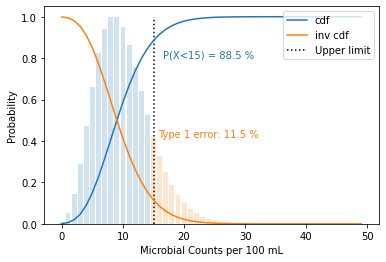

In [97]:
mu = 10  # CFU/100mL
var = 2*mu
p = mu / var
n = mu * p / (1-p)
print(mu, var, p, n )

ual = 15  # upper acceptance limit'
nb = stats.nbinom(n=n, p=p)
xhat = np.arange(0,50)
yhat = nb.cdf(xhat)
yhat1 = nb.sf(xhat)
x0 = xhat[xhat<ual]
x1 = xhat[xhat>=ual]
yd0 = nb.pmf(x0)
yd1 = nb.pmf(x1)
yd = nb.pmf(xhat)

plt.plot(xhat, yhat, label='cdf')
plt.plot(xhat, yhat1, label='inv cdf')
#plt.bar(xhat, yd/yd.max(), alpha=0.2)
plt.bar(x0, yd0/yd0.max(), alpha=0.2)
plt.bar(x1, yd1/yd0.max(), alpha=0.2)
plt.vlines(ymin=0, ymax=1, x=ual, color='black', linestyle=':', label='Upper limit')
plt.text(x=ual*1.1, y=0.8, 
         s=f'P(X<{ual:0.0f}) = {nb.cdf(ual)*100:0.1f} %',
         color='C0')
plt.text(x=ual*1.05, y=max(yd1/yd0.max()), 
         s=f'Type 1 error: {nb.sf(ual)*100:0.1f} %', 
         color='C1')

plt.hist()
plt.legend(loc=1)
plt.xlabel('Microbial Counts per 100 mL')
plt.ylabel('Probability')
